In [1]:
from dotenv import load_dotenv
load_dotenv()

True

Define tool functions that we can use in our graph.

In [2]:
from langchain_core.tools import tool

# Tools

@tool
def get_projects():
    """
    Returns a list of mock time entry projects for a software consulting company.
    Each project includes client name, project name, and project ID.
    """
    return [
        {
            "client_name": "Acme Corporation",
            "project_name": "E-commerce Platform Redesign",
            "project_id": "aef12d88-e0ae-4949-b7a2-7704f3b0c1d0"
        },
        {
            "client_name": "TechNova Inc.",
            "project_name": "Mobile App Development",
            "project_id": "b57cf8e2-3714-4b83-9d63-afcd23e0f87b"
        },
        {
            "client_name": "Global Finance Group",
            "project_name": "Payment Processing System",
            "project_id": "c982b427-59a5-4c5e-b3f6-76ae4c1d9e5d"
        },
        {
            "client_name": "HealthCare Solutions",
            "project_name": "Patient Management Portal",
            "project_id": "d341f57a-6890-4f13-a8de-92c23481b6c2"
        },
        {
            "client_name": "EduTech Ventures",
            "project_name": "Learning Management System",
            "project_id": "e725d1b9-4a07-41b8-9c15-3f7b60c84a36"
        },
        {
            "client_name": "Intertech",
            "project_name": "Paid Time Off",
            "project_id": "f109e384-5c27-49f5-b651-48e72a0dca7f"
        }
    ]

@tool
def book_time_entry(projectId: str, date, hours: int = 8):
    """
    Book time entry for a project.
    Args:
        projectId (str): The unique ID of the project.
        date (str): The date for the time entry.
        hours (int): The number of hours to book.
    """
    return f"Booked {hours} hours on {date} for {projectId}."

tools = [get_projects, book_time_entry]

Define a langauage model and bind the tools.

In [3]:
from langchain_anthropic import ChatAnthropic

# Language Model
llm = ChatAnthropic(model="claude-3-7-sonnet-20250219")
llm = llm.bind_tools(tools)

Define a function that can choose a tools node.

In [4]:
from langgraph.graph import MessagesState, END


def route_tools(state: MessagesState,  messages_key: str = "messages",):
    """
    Route to a tools node based on the name of the tool.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif isinstance(state, dict) and (messages := state.get(messages_key, [])):
        ai_message = messages[-1]
    elif messages := getattr(state, messages_key, []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        next = ai_message.tool_calls[0]["name"]
        print(f"Routing to tool: {next}")
        return next
    
    return END

Define a graph that has two tool nodes with a custom conditional edge function that routes by node name.

In [5]:
from datetime import date
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START
from langgraph.prebuilt import ToolNode

# Graph
builder = StateGraph(MessagesState)

# System message
sys_msg = SystemMessage(content=f"""
    You are a helpful assistant tasked with helping Intertech employees track time spent on projects.
    Today is {date.today().isoformat()}.
    """)

# Nodes

def assistant(state: MessagesState):
    return {"messages": [llm.invoke([sys_msg] + state["messages"])]}

builder.add_node("assistant", assistant)
builder.add_node("get_projects", ToolNode([get_projects]))
builder.add_node("book_time_entry", ToolNode([book_time_entry]))

# Edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", route_tools)
builder.add_edge("get_projects", "assistant")
builder.add_edge("book_time_entry", "assistant")

# Build the graph
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

Display the graph.

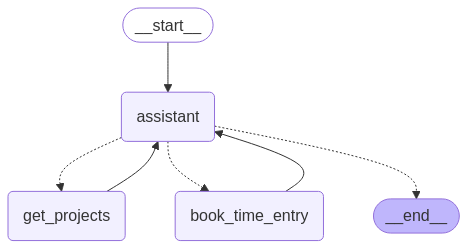

In [6]:

from IPython.display import Image, display

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": "1"}}

messages = [HumanMessage(content="I took PTO on Monday.")]
messages = graph.invoke({"messages": messages}, config)

for m in messages['messages']:
    m.pretty_print()